In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [2]:
def open_single_dataset(*args, **kwargs):
    xds = xr.open_dataset(*args, **kwargs)
    xds = xds.resample(delta_t="5s").mean()
    for key in xds.data_vars:
        xds[key] = xds[key] * 9.31e-10
        xds[key].attrs["units"] = "GiB"

    minutes = xds["delta_t"].values.astype("<m8[s]").astype(int)/60
    xds["minutes"] = xr.DataArray(minutes, xds["delta_t"].coords, xds["delta_t"].dims)
    xds = xds.swap_dims({"delta_t": "minutes"})

    for key in xds.data_vars:
        xds[f"{key}_walltime"] = xds[key].minutes.where(~np.isnan(xds[key])).max("minutes")
    return xds

In [3]:
def open_dataset(branches=("main", "slots"),n_years=(1,5),n_nodes=(1,)):
    dslist = []
    for branch in branches:
        for yr in n_years:
            for n_node in n_nodes:
                fname = f"output-training-{branch}-{yr}year-{n_node}node/memory_sampling.nc"
                xds = open_single_dataset(fname)
                xds = xds.rename({f"training_{branch}_{yr}year_{n_node}node": "training"})
                xds = xds.rename({f"training_{branch}_{yr}year_{n_node}node_walltime": "training_walltime"})
                xds = xds.expand_dims({
                    "branch": [branch],
                    "n_years": [yr],
                    "n_nodes": [n_node],
                })
                dslist.append(xds)
    return xr.merge(dslist)

In [4]:
ds = open_dataset()

In [5]:
ds["branch"] = ds["branch"].astype(str)

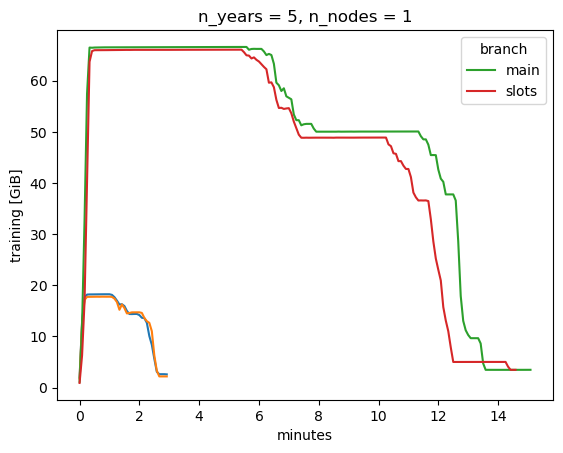

In [6]:
for n_years, ls in zip([1,5], ["--", "-"]):
    ds.training.sel(n_years=n_years).squeeze().plot.line(x="minutes")

In [7]:
ds.training.squeeze().max("minutes")

<xarray.DataArray 'training' (branch: 2, n_years: 2)>
array([[18.25639384, 66.60165709],
       [17.7827836 , 66.06597347]])
Coordinates:
  * branch   (branch) <U5 'main' 'slots'
  * n_years  (n_years) int64 1 5
    n_nodes  int64 1

In [8]:
ds.training_walltime.squeeze()

<xarray.DataArray 'training_walltime' (branch: 2, n_years: 2)>
array([[ 2.91666667, 15.08333333],
       [ 2.91666667, 14.58333333]])
Coordinates:
  * branch   (branch) <U5 'main' 'slots'
  * n_years  (n_years) int64 1 5
    n_nodes  int64 1